<h2 align="center">Car Damage Detection Project</h2>

**Overview**

The objective of this project is to develop a Proof of Concept (POC) for car damage detection 
that can classify the condition of a car's front and rear into six predefined categories. The 
solution will be delivered as a trained machine learning model integrated into a Streamlit 
app.

**Problem Statement**

Build a POC for detecting car damage based on uploaded car images. The model should 
classify car damage into six possible categories with an accuracy of at least 75%. The 
categories are: 
1. Front Normal 
2. Front Breakage 
3. Front Crushed 
4. Rear Normal 
5. Rear Breakage 
6. Rear Crushed 

## Import Library

In [112]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import time
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Data

### Transformation on Image

In [45]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(.15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [46]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)


#### Length of dataset

In [47]:
len(dataset)

2300

### Classes in Dataset

In [48]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [49]:
num_of_classes = len(dataset.classes)
num_of_classes

6

In [50]:
# Get one sample
image, label = dataset[0]
print("Image tensor shape:", image.shape)
print("Label:", dataset.classes[label])

Image tensor shape: torch.Size([3, 224, 224])
Label: F_Breakage


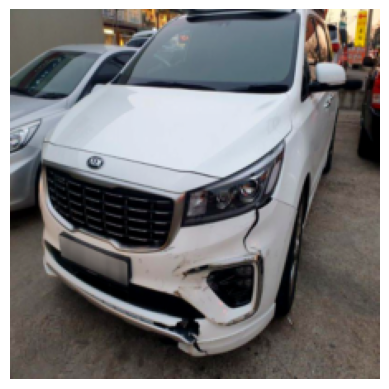

In [51]:
# Helper to unnormalize for visualization
def imshow(img_tensor):
    img = img_tensor.clone()  # clone so we don’t alter original
    img = img.numpy().transpose((1, 2, 0))  # CHW → HWC
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean   # unnormalize
    img = img.clip(0, 1)     # keep in range
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Show transformed image
imshow(image)

### Class Distribution


In [52]:
from collections import Counter
# Count occurrences of each class index
class_counts = Counter(dataset.targets)

# Map class indices → class names
idx_to_class = {v : k for k, v in dataset.class_to_idx.items()}
class_counts_named = {idx_to_class[idx]: count for idx, count in class_counts.items()}

print("Class distribution:", class_counts_named)

Class distribution: {'F_Breakage': 500, 'F_Crushed': 400, 'F_Normal': 500, 'R_Breakage': 300, 'R_Crushed': 300, 'R_Normal': 300}


### Split data into Train, Test, and Validation size

In [53]:
# Length of dataset
total_size = len(dataset)
train_size = int(0.6 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size-train_size-test_size
print(f"Dataset Total size: {total_size} → Train: {train_size}, Val: {val_size}, Test: {test_size}")

Dataset Total size: 2300 → Train: 1380, Val: 460, Test: 460


In [54]:
# Use random_split with a fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)  # fix seed
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=generator
)

In [55]:
"""
Maintaining Class Imbalace  

# Get labels for stratification
targets = np.array(dataset.targets)   # dataset.targets holds class indices

# First split → Train (60%) vs Temp (40%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.4,
    stratify=targets,
    random_state=42
)

# Second split → Validation (20%) vs Test (20%)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,   # 50% of 40% → 20% each
    stratify=targets[temp_idx],
    random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

print(f"Dataset sizes → Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

"""

'\nMaintaining Class Imbalace  \n\n# Get labels for stratification\ntargets = np.array(dataset.targets)   # dataset.targets holds class indices\n\n# First split → Train (60%) vs Temp (40%)\ntrain_idx, temp_idx = train_test_split(\n    np.arange(len(targets)),\n    test_size=0.4,\n    stratify=targets,\n    random_state=42\n)\n\n# Second split → Validation (20%) vs Test (20%)\nval_idx, test_idx = train_test_split(\n    temp_idx,\n    test_size=0.5,   # 50% of 40% → 20% each\n    stratify=targets[temp_idx],\n    random_state=42\n)\n\n# Create subsets\ntrain_dataset = Subset(dataset, train_idx)\nval_dataset   = Subset(dataset, val_idx)\ntest_dataset  = Subset(dataset, test_idx)\n\nprint(f"Dataset sizes → Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")\n\n'

In [56]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [58]:
images[0].shape

torch.Size([3, 224, 224])

In [59]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


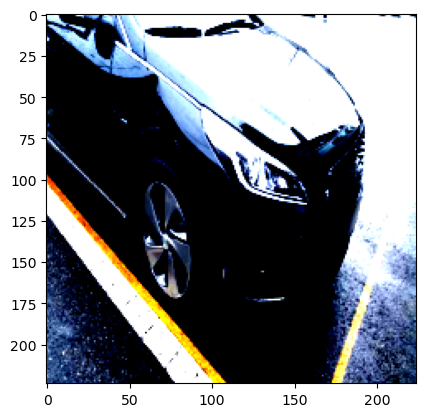

In [60]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1: Convolutional Neural Network (CNN)

#### Define Model Architecture

In [91]:
class CarDamageClassificationCnn(nn.Module):
    def __init__(self, num_of_classes):
        super().__init__()
        self.network = nn.Sequential(
            # 1st Layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112,112)

            # 2nd Layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)

            # 3rd Layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)

            
            # Flatten Layer converts feature maps (64,28,28) into 1D -> 64*28*28 = 50176 features. Hence Shape become (50176,) per Image
            nn.Flatten(),

            # Fully Connected Layers (Dense Layers)
            nn.Linear(64*28*28, 512), # (50,176 × 512) + 512 = 25,690,624 params
            nn.ReLU(),
            nn.Linear(512, num_of_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x



#### Train and Validate Model

In [92]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train() # set to training mode
        training_loss, correct, total = 0.0, 0.0, 0.0
        
        
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Fordward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = training_loss / len(train_loader)
        

        #     training_loss += loss.item() * images.size(0)

        # epoch_loss = training_loss / len(train_loader.dataset)
        # print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")


        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0.0, 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs,1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

            print(f"*** Validation Accuracy: {100 * val_correct / val_total:.2f}% ***")

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
    end = time.time()
    print(f"Execution time: {end - start} seconds") 
    return model

### Test Model

In [93]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Accuracy
    model_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"***Test Accuracy: {model_accuracy:.2f}%***")

    return all_preds, all_labels


#### Run Model Training, Evaluation and Testing

In [94]:
# Instantiate the model, loss function and optimizer

# Initialize model
class_names = dataset.classes  # from your ImageFolder
num_of_classes = len(dataset.classes)
model = CarDamageClassificationCnn(num_of_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Batch: 10, Epoch: 1, Loss: 1.74
Batch: 20, Epoch: 1, Loss: 1.61
Batch: 30, Epoch: 1, Loss: 1.50
Batch: 40, Epoch: 1, Loss: 1.64
*** Validation Accuracy: 36.09% ***
Epoch [1/10] Train Loss: 1.8041, Train Acc: 28.99% | Val Loss: 1.6289, Val Acc: 36.09%
Batch: 10, Epoch: 2, Loss: 1.52
Batch: 20, Epoch: 2, Loss: 1.36
Batch: 30, Epoch: 2, Loss: 1.34
Batch: 40, Epoch: 2, Loss: 1.34
*** Validation Accuracy: 50.22% ***
Epoch [2/10] Train Loss: 1.4158, Train Acc: 43.12% | Val Loss: 1.2979, Val Acc: 50.22%
Batch: 10, Epoch: 3, Loss: 1.23
Batch: 20, Epoch: 3, Loss: 1.44
Batch: 30, Epoch: 3, Loss: 1.21
Batch: 40, Epoch: 3, Loss: 0.98
*** Validation Accuracy: 53.48% ***
Epoch [3/10] Train Loss: 1.2060, Train Acc: 50.80% | Val Loss: 1.1449, Val Acc: 53.48%
Batch: 10, Epoch: 4, Loss: 1.08
Batch: 20, Epoch: 4, Loss: 1.15
Batch: 30, Epoch: 4, Loss: 1.04
Batch: 40, Epoch: 4, Loss: 0.98
*** Validation Accuracy: 51.30% ***
Epoch [4/10] Train Loss: 1.0547, Train Acc: 58.33% | Val Loss: 1.2138, Val Acc: 51.

In [106]:
# Evaluate on test set
all_preds, all_labels = test_model(trained_model, test_loader)

***Test Accuracy: 55.00%***


## Classification report 

In [118]:
def classification_report_matrix(all_labels, all_preds, class_names):

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

In [114]:
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       103
           1       0.45      0.60      0.52        80
           2       0.91      0.63      0.74        97
           3       0.31      0.25      0.28        56
           4       0.50      0.55      0.53        74
           5       0.63      0.48      0.55        50

    accuracy                           0.55       460
   macro avg       0.56      0.52      0.53       460
weighted avg       0.58      0.55      0.55       460



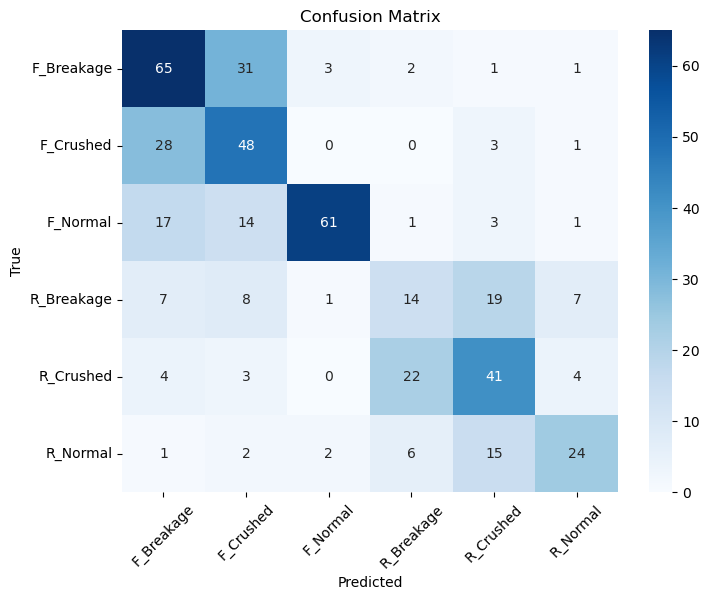

In [119]:
classification_report_matrix(all_labels, all_preds, class_names)

### Model 2: CNN with Regularization

In [120]:
class CarDamagerClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            # 1st Layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),

            # 2st Layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)   

            # 3st Layer        
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),

            nn.Flatten(),
            
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

#### Run Model Training, Evaluation and Testing

In [123]:
# Instantiate the model, loss function and optimizer

# Initialize model
class_names = dataset.classes  # from your ImageFolder
num_of_classes = len(dataset.classes)
model_with_regularization = CarDamagerClassifierCNNWithRegularization(num_of_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_regularization.parameters(), lr=0.001, weight_decay=1e-4)

trained_model_with_regularization = train_model(model_with_regularization, train_loader, val_loader, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 15.40
Batch: 20, Epoch: 1, Loss: 7.29
Batch: 30, Epoch: 1, Loss: 1.91
Batch: 40, Epoch: 1, Loss: 1.80
*** Validation Accuracy: 34.78% ***
Epoch [1/10] Train Loss: 8.0183, Train Acc: 27.46% | Val Loss: 1.6025, Val Acc: 34.78%
Batch: 10, Epoch: 2, Loss: 1.66
Batch: 20, Epoch: 2, Loss: 1.32
Batch: 30, Epoch: 2, Loss: 1.64
Batch: 40, Epoch: 2, Loss: 1.68
*** Validation Accuracy: 40.22% ***
Epoch [2/10] Train Loss: 1.5742, Train Acc: 33.77% | Val Loss: 1.4908, Val Acc: 40.22%
Batch: 10, Epoch: 3, Loss: 1.61
Batch: 20, Epoch: 3, Loss: 1.48
Batch: 30, Epoch: 3, Loss: 1.37
Batch: 40, Epoch: 3, Loss: 1.60
*** Validation Accuracy: 44.13% ***
Epoch [3/10] Train Loss: 1.5183, Train Acc: 34.13% | Val Loss: 1.3833, Val Acc: 44.13%
Batch: 10, Epoch: 4, Loss: 1.35
Batch: 20, Epoch: 4, Loss: 1.47
Batch: 30, Epoch: 4, Loss: 1.43
Batch: 40, Epoch: 4, Loss: 1.44
*** Validation Accuracy: 45.87% ***
Epoch [4/10] Train Loss: 1.4407, Train Acc: 41.59% | Val Loss: 1.3120, Val Acc: 45

***Test Accuracy: 42.61%***
Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.82      0.55       103
           1       0.14      0.01      0.02        80
           2       0.84      0.60      0.70        97
           3       0.23      0.36      0.28        56
           4       0.53      0.11      0.18        74
           5       0.31      0.50      0.38        50

    accuracy                           0.43       460
   macro avg       0.41      0.40      0.35       460
weighted avg       0.44      0.43      0.38       460



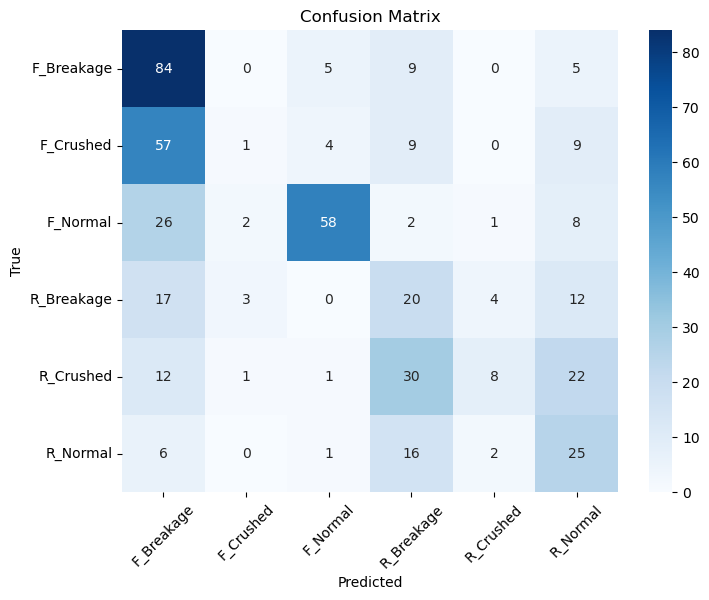

In [125]:
# Evaluate on test set
all_preds, all_labels = test_model(trained_model_with_regularization, test_loader)
classification_report_matrix(all_labels, all_preds, class_names)

### Model 3: Transfer Learning with EfficientNet

In [ ]:
# model_efficientnet_b0 = models.efficientnet_b0(weights='DEFAULT')


#### Modify EfficientNet Pre-trained model Architecture

In [ ]:
class CarDamageClassifierEfficientNet(nn.Module):
    def __init__(self, num_of_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Stop updating weights for convolution layer
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features

        # Replace the final fully connected layer
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_of_classes)
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

#### Run Model Training, Evaluation and Testing

In [137]:

class_names = dataset.classes  # from your ImageFolder
num_of_classes = len(dataset.classes)

# Initialize model
model_efficientnet_b0 = CarDamageClassifierEfficientNet(num_of_classes=num_of_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_efficientnet_b0.parameters()), lr=0.001)
trained_model_with_efficient = train_model(model_efficientnet_b0, train_loader, val_loader, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.02
Batch: 20, Epoch: 1, Loss: 1.20
Batch: 30, Epoch: 1, Loss: 0.67
Batch: 40, Epoch: 1, Loss: 0.87
*** Validation Accuracy: 69.35% ***
Epoch [1/1] Train Loss: 0.9358, Train Acc: 60.94% | Val Loss: 0.8120, Val Acc: 69.35%
Execution time: 276.6782970428467 seconds


***Test Accuracy: 68.70%***
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       103
           1       0.68      0.72      0.70        80
           2       0.96      0.68      0.80        97
           3       0.68      0.34      0.45        56
           4       0.52      0.55      0.54        74
           5       0.53      0.76      0.62        50

    accuracy                           0.69       460
   macro avg       0.68      0.66      0.65       460
weighted avg       0.71      0.69      0.68       460



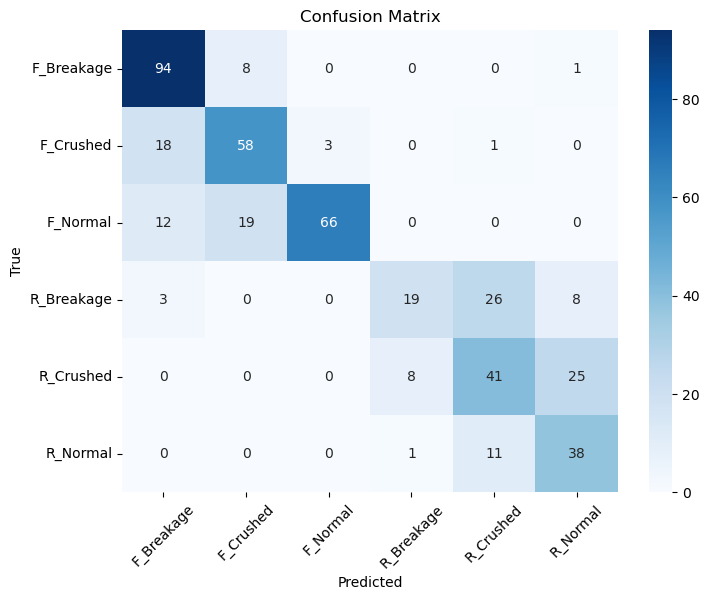

In [138]:
# Evaluate on test set
all_preds, all_labels = test_model(trained_model_with_efficient, test_loader)
classification_report_matrix(all_labels, all_preds, class_names)

### Model 4: Transfer Learning with ResNet

In [ ]:
# Modify ResNet architecture
class CarDamageClassifierResNet(nn.Module):
    def __init__(self, num_of_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_of_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [145]:
# Initialize model
model_resnet50 = CarDamageClassifierResNet(num_of_classes=num_of_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=0.001)
trained_model_with_resnet = train_model(model_resnet50, train_loader, val_loader, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.79
Batch: 20, Epoch: 1, Loss: 0.77
Batch: 30, Epoch: 1, Loss: 0.98
Batch: 40, Epoch: 1, Loss: 0.84
*** Validation Accuracy: 69.57% ***
Epoch [1/10] Train Loss: 0.9452, Train Acc: 62.61% | Val Loss: 0.8274, Val Acc: 69.57%
Batch: 10, Epoch: 2, Loss: 0.77
Batch: 20, Epoch: 2, Loss: 0.70
Batch: 30, Epoch: 2, Loss: 0.41
Batch: 40, Epoch: 2, Loss: 0.46
*** Validation Accuracy: 72.17% ***
Epoch [2/10] Train Loss: 0.5625, Train Acc: 78.33% | Val Loss: 0.6763, Val Acc: 72.17%
Batch: 10, Epoch: 3, Loss: 0.36
Batch: 20, Epoch: 3, Loss: 0.53
Batch: 30, Epoch: 3, Loss: 0.48
Batch: 40, Epoch: 3, Loss: 0.14
*** Validation Accuracy: 72.61% ***
Epoch [3/10] Train Loss: 0.3651, Train Acc: 85.65% | Val Loss: 0.6664, Val Acc: 72.61%
Batch: 10, Epoch: 4, Loss: 0.27
Batch: 20, Epoch: 4, Loss: 0.20
Batch: 30, Epoch: 4, Loss: 0.11
Batch: 40, Epoch: 4, Loss: 0.29
*** Validation Accuracy: 76.09% ***
Epoch [4/10] Train Loss: 0.2750, Train Acc: 91.01% | Val Loss: 0.6178, Val Acc: 76.

***Test Accuracy: 76.52%***
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       103
           1       0.69      0.80      0.74        80
           2       0.85      0.88      0.86        97
           3       0.67      0.68      0.67        56
           4       0.69      0.65      0.67        74
           5       0.73      0.82      0.77        50

    accuracy                           0.77       460
   macro avg       0.75      0.76      0.75       460
weighted avg       0.77      0.77      0.77       460



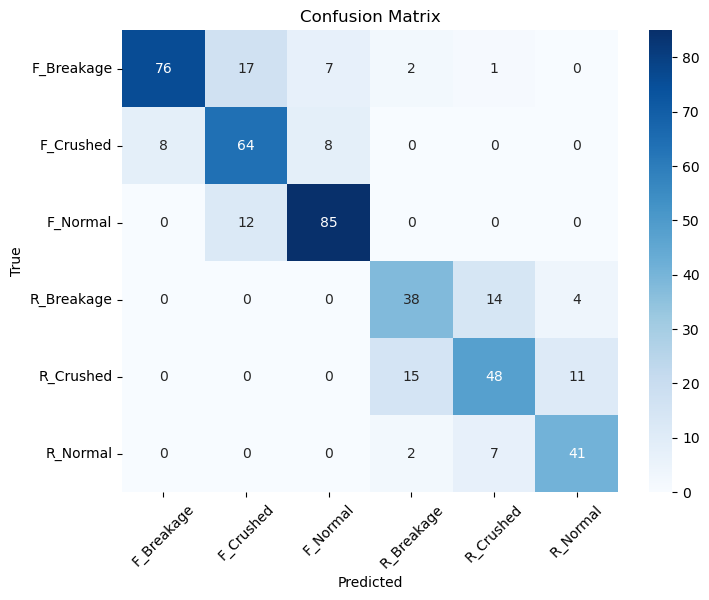

In [146]:
# Evaluate on test set
all_preds, all_labels = test_model(trained_model_with_resnet, test_loader)
classification_report_matrix(all_labels, all_preds, class_names)

### Model Training & Hyperparameter Tunning With Optuna

In [171]:
import optuna
import torch.optim as optim

# Define the Objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Load the model
    model = CarDamageClassifierResNet(num_of_classes=num_of_classes, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3 #3
    start = time.time()

    for epoch in range(epochs):
        model.train() # set to training mode
        training_loss, correct, total = 0.0, 0.0, 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Fordward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = training_loss / len(train_loader)


        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0.0, 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs,1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        # Avoid division by zero
        if val_total > 0:
            val_acc = 100 * val_correct / val_total
        else:
            val_acc = 0.0

        if len(val_loader) > 0:
            avg_val_loss = val_loss / len(val_loader)
        else:
            avg_val_loss = float("inf")

        print(f"*** Validation Accuracy: {val_acc:.2f}% ***")

        # Report intermediate result to Optuna
        trial.report(val_acc, epoch)

        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return val_acc



In [172]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) #20

[I 2025-08-21 07:19:31,422] A new study created in memory with name: no-name-207692a1-93b0-43c6-b41a-edb96fdf8cc5


Batch: 10, Epoch: 1, Loss: 1.75
Batch: 20, Epoch: 1, Loss: 1.09
Batch: 30, Epoch: 1, Loss: 0.98
Batch: 40, Epoch: 1, Loss: 1.14
*** Validation Accuracy: 70.87% ***
Epoch [1/3] Train Loss: 1.1483, Train Acc: 53.04% | Val Loss: 0.6930, Val Acc: 70.87%
Batch: 10, Epoch: 2, Loss: 0.45
Batch: 20, Epoch: 2, Loss: 0.63
Batch: 30, Epoch: 2, Loss: 0.30
Batch: 40, Epoch: 2, Loss: 0.72
*** Validation Accuracy: 76.52% ***
Epoch [2/3] Train Loss: 0.4935, Train Acc: 81.59% | Val Loss: 0.6294, Val Acc: 76.52%
Batch: 10, Epoch: 3, Loss: 0.26
Batch: 20, Epoch: 3, Loss: 0.16
Batch: 30, Epoch: 3, Loss: 0.31
Batch: 40, Epoch: 3, Loss: 0.29


[I 2025-08-21 07:28:42,144] Trial 0 finished with value: 76.08695652173913 and parameters: {'lr': 0.0003737775275961115, 'dropout_rate': 0.4778432496941226}. Best is trial 0 with value: 76.08695652173913.


*** Validation Accuracy: 76.09% ***
Epoch [3/3] Train Loss: 0.2968, Train Acc: 88.84% | Val Loss: 0.6703, Val Acc: 76.09%
Execution time: 550.1550390720367 seconds
Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.80
Batch: 40, Epoch: 1, Loss: 1.75
*** Validation Accuracy: 25.65% ***
Epoch [1/3] Train Loss: 1.7902, Train Acc: 18.55% | Val Loss: 1.7570, Val Acc: 25.65%
Batch: 10, Epoch: 2, Loss: 1.70
Batch: 20, Epoch: 2, Loss: 1.77
Batch: 30, Epoch: 2, Loss: 1.72
Batch: 40, Epoch: 2, Loss: 1.77
*** Validation Accuracy: 32.39% ***
Epoch [2/3] Train Loss: 1.7454, Train Acc: 27.17% | Val Loss: 1.7221, Val Acc: 32.39%
Batch: 10, Epoch: 3, Loss: 1.68
Batch: 20, Epoch: 3, Loss: 1.70
Batch: 30, Epoch: 3, Loss: 1.74
Batch: 40, Epoch: 3, Loss: 1.64


[I 2025-08-21 07:37:48,238] Trial 1 finished with value: 36.08695652173913 and parameters: {'lr': 1.144483087667378e-05, 'dropout_rate': 0.6017762423530497}. Best is trial 0 with value: 76.08695652173913.


*** Validation Accuracy: 36.09% ***
Epoch [3/3] Train Loss: 1.6908, Train Acc: 33.26% | Val Loss: 1.6749, Val Acc: 36.09%
Execution time: 545.6662540435791 seconds
Batch: 10, Epoch: 1, Loss: 1.61
Batch: 20, Epoch: 1, Loss: 1.24
Batch: 30, Epoch: 1, Loss: 1.05
Batch: 40, Epoch: 1, Loss: 0.67
*** Validation Accuracy: 68.04% ***
Epoch [1/3] Train Loss: 1.2562, Train Acc: 50.14% | Val Loss: 0.8601, Val Acc: 68.04%
Batch: 10, Epoch: 2, Loss: 0.71
Batch: 20, Epoch: 2, Loss: 0.54
Batch: 30, Epoch: 2, Loss: 0.53
Batch: 40, Epoch: 2, Loss: 0.55
*** Validation Accuracy: 73.26% ***
Epoch [2/3] Train Loss: 0.5626, Train Acc: 78.70% | Val Loss: 0.6812, Val Acc: 73.26%
Batch: 10, Epoch: 3, Loss: 0.38
Batch: 20, Epoch: 3, Loss: 0.43
Batch: 30, Epoch: 3, Loss: 0.15
Batch: 40, Epoch: 3, Loss: 0.18


[I 2025-08-21 07:49:10,677] Trial 2 finished with value: 72.6086956521739 and parameters: {'lr': 0.0002452234151856414, 'dropout_rate': 0.38695641547438875}. Best is trial 0 with value: 76.08695652173913.


*** Validation Accuracy: 72.61% ***
Epoch [3/3] Train Loss: 0.2975, Train Acc: 88.19% | Val Loss: 0.7090, Val Acc: 72.61%
Execution time: 682.0890049934387 seconds
Batch: 10, Epoch: 1, Loss: 0.85
Batch: 20, Epoch: 1, Loss: 0.83
Batch: 30, Epoch: 1, Loss: 0.75
Batch: 40, Epoch: 1, Loss: 0.38
*** Validation Accuracy: 68.48% ***
Epoch [1/3] Train Loss: 0.8889, Train Acc: 62.54% | Val Loss: 1.0331, Val Acc: 68.48%
Batch: 10, Epoch: 2, Loss: 0.54
Batch: 20, Epoch: 2, Loss: 0.59
Batch: 30, Epoch: 2, Loss: 0.58
Batch: 40, Epoch: 2, Loss: 0.46
*** Validation Accuracy: 72.17% ***
Epoch [2/3] Train Loss: 0.5124, Train Acc: 79.93% | Val Loss: 0.6991, Val Acc: 72.17%
Batch: 10, Epoch: 3, Loss: 0.23
Batch: 20, Epoch: 3, Loss: 0.39
Batch: 30, Epoch: 3, Loss: 0.31
Batch: 40, Epoch: 3, Loss: 0.34


[I 2025-08-21 07:58:32,661] Trial 3 finished with value: 80.43478260869566 and parameters: {'lr': 0.001734061566261664, 'dropout_rate': 0.30996537140640806}. Best is trial 3 with value: 80.43478260869566.


*** Validation Accuracy: 80.43% ***
Epoch [3/3] Train Loss: 0.3847, Train Acc: 85.94% | Val Loss: 0.6367, Val Acc: 80.43%
Execution time: 561.6326189041138 seconds
Batch: 10, Epoch: 1, Loss: 1.43
Batch: 20, Epoch: 1, Loss: 1.04
Batch: 30, Epoch: 1, Loss: 0.79
Batch: 40, Epoch: 1, Loss: 0.71
*** Validation Accuracy: 71.96% ***
Epoch [1/3] Train Loss: 1.0014, Train Acc: 60.80% | Val Loss: 0.7058, Val Acc: 71.96%
Batch: 10, Epoch: 2, Loss: 0.33
Batch: 20, Epoch: 2, Loss: 0.50
Batch: 30, Epoch: 2, Loss: 0.42
Batch: 40, Epoch: 2, Loss: 0.58
*** Validation Accuracy: 71.30% ***
Epoch [2/3] Train Loss: 0.5081, Train Acc: 81.01% | Val Loss: 0.7419, Val Acc: 71.30%
Batch: 10, Epoch: 3, Loss: 0.27
Batch: 20, Epoch: 3, Loss: 0.32
Batch: 30, Epoch: 3, Loss: 0.31
Batch: 40, Epoch: 3, Loss: 0.75


[I 2025-08-21 08:11:26,802] Trial 4 finished with value: 74.78260869565217 and parameters: {'lr': 0.0006676265919577619, 'dropout_rate': 0.6420427825826103}. Best is trial 3 with value: 80.43478260869566.


*** Validation Accuracy: 74.78% ***
Epoch [3/3] Train Loss: 0.3026, Train Acc: 89.06% | Val Loss: 0.7454, Val Acc: 74.78%
Execution time: 773.7043919563293 seconds
Batch: 10, Epoch: 1, Loss: 1.48
Batch: 20, Epoch: 1, Loss: 1.24
Batch: 30, Epoch: 1, Loss: 0.51
Batch: 40, Epoch: 1, Loss: 0.65


[I 2025-08-21 08:15:08,530] Trial 5 pruned. 


*** Validation Accuracy: 68.26% ***
Batch: 10, Epoch: 1, Loss: 1.58
Batch: 20, Epoch: 1, Loss: 0.96
Batch: 30, Epoch: 1, Loss: 1.18
Batch: 40, Epoch: 1, Loss: 0.92
*** Validation Accuracy: 70.22% ***
Epoch [1/3] Train Loss: 1.0147, Train Acc: 60.29% | Val Loss: 0.7689, Val Acc: 70.22%
Batch: 10, Epoch: 2, Loss: 0.52
Batch: 20, Epoch: 2, Loss: 0.49
Batch: 30, Epoch: 2, Loss: 0.54
Batch: 40, Epoch: 2, Loss: 0.40
*** Validation Accuracy: 72.61% ***
Epoch [2/3] Train Loss: 0.5122, Train Acc: 78.26% | Val Loss: 0.8222, Val Acc: 72.61%
Batch: 10, Epoch: 3, Loss: 0.34
Batch: 20, Epoch: 3, Loss: 0.35
Batch: 30, Epoch: 3, Loss: 0.29
Batch: 40, Epoch: 3, Loss: 0.27


[I 2025-08-21 08:24:29,497] Trial 6 pruned. 


*** Validation Accuracy: 72.83% ***
Batch: 10, Epoch: 1, Loss: 1.68
Batch: 20, Epoch: 1, Loss: 1.57
Batch: 30, Epoch: 1, Loss: 1.39
Batch: 40, Epoch: 1, Loss: 1.35


[I 2025-08-21 08:27:40,414] Trial 7 pruned. 


*** Validation Accuracy: 52.83% ***
Batch: 10, Epoch: 1, Loss: 1.18
Batch: 20, Epoch: 1, Loss: 0.88
Batch: 30, Epoch: 1, Loss: 0.63
Batch: 40, Epoch: 1, Loss: 0.94


[I 2025-08-21 08:30:51,566] Trial 8 pruned. 


*** Validation Accuracy: 59.13% ***
Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.78
Batch: 40, Epoch: 1, Loss: 1.77


[I 2025-08-21 08:34:01,110] Trial 9 pruned. 


*** Validation Accuracy: 32.83% ***
Batch: 10, Epoch: 1, Loss: 1.09
Batch: 20, Epoch: 1, Loss: 1.13
Batch: 30, Epoch: 1, Loss: 0.86
Batch: 40, Epoch: 1, Loss: 0.67


[I 2025-08-21 08:37:08,549] Trial 10 pruned. 


*** Validation Accuracy: 66.30% ***
Batch: 10, Epoch: 1, Loss: 1.09
Batch: 20, Epoch: 1, Loss: 0.76
Batch: 30, Epoch: 1, Loss: 0.74
Batch: 40, Epoch: 1, Loss: 0.42


[I 2025-08-21 08:40:14,827] Trial 11 pruned. 


*** Validation Accuracy: 66.52% ***
Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.63
Batch: 30, Epoch: 1, Loss: 1.52
Batch: 40, Epoch: 1, Loss: 1.50


[I 2025-08-21 08:43:30,542] Trial 12 pruned. 


*** Validation Accuracy: 45.22% ***
Batch: 10, Epoch: 1, Loss: 0.89
Batch: 20, Epoch: 1, Loss: 0.96
Batch: 30, Epoch: 1, Loss: 0.87
Batch: 40, Epoch: 1, Loss: 0.75


[I 2025-08-21 08:46:40,637] Trial 13 pruned. 


*** Validation Accuracy: 68.04% ***
Batch: 10, Epoch: 1, Loss: 1.72
Batch: 20, Epoch: 1, Loss: 1.69
Batch: 30, Epoch: 1, Loss: 1.66
Batch: 40, Epoch: 1, Loss: 1.37


[I 2025-08-21 08:49:52,633] Trial 14 pruned. 


*** Validation Accuracy: 45.65% ***
Batch: 10, Epoch: 1, Loss: 1.03
Batch: 20, Epoch: 1, Loss: 0.73
Batch: 30, Epoch: 1, Loss: 0.90
Batch: 40, Epoch: 1, Loss: 0.66


[I 2025-08-21 08:53:12,195] Trial 15 pruned. 


*** Validation Accuracy: 67.83% ***
Batch: 10, Epoch: 1, Loss: 1.31
Batch: 20, Epoch: 1, Loss: 0.79
Batch: 30, Epoch: 1, Loss: 0.78
Batch: 40, Epoch: 1, Loss: 0.59
*** Validation Accuracy: 71.30% ***
Epoch [1/3] Train Loss: 1.0058, Train Acc: 59.49% | Val Loss: 0.7878, Val Acc: 71.30%
Batch: 10, Epoch: 2, Loss: 0.44
Batch: 20, Epoch: 2, Loss: 0.37
Batch: 30, Epoch: 2, Loss: 0.30
Batch: 40, Epoch: 2, Loss: 0.74
*** Validation Accuracy: 75.00% ***
Epoch [2/3] Train Loss: 0.4996, Train Acc: 81.01% | Val Loss: 0.6972, Val Acc: 75.00%
Batch: 10, Epoch: 3, Loss: 0.22
Batch: 20, Epoch: 3, Loss: 0.25
Batch: 30, Epoch: 3, Loss: 0.11
Batch: 40, Epoch: 3, Loss: 0.46


[I 2025-08-21 09:02:56,219] Trial 16 finished with value: 75.43478260869566 and parameters: {'lr': 0.0005927340799401189, 'dropout_rate': 0.5889516265726803}. Best is trial 3 with value: 80.43478260869566.


*** Validation Accuracy: 75.43% ***
Epoch [3/3] Train Loss: 0.2821, Train Acc: 89.86% | Val Loss: 0.7572, Val Acc: 75.43%
Execution time: 583.5923781394958 seconds
Batch: 10, Epoch: 1, Loss: 1.21
Batch: 20, Epoch: 1, Loss: 0.82
Batch: 30, Epoch: 1, Loss: 0.99
Batch: 40, Epoch: 1, Loss: 0.89


[I 2025-08-21 09:06:12,620] Trial 17 pruned. 


*** Validation Accuracy: 58.26% ***
Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.77
Batch: 30, Epoch: 1, Loss: 1.71
Batch: 40, Epoch: 1, Loss: 1.70


[I 2025-08-21 09:09:24,369] Trial 18 pruned. 


*** Validation Accuracy: 44.35% ***
Batch: 10, Epoch: 1, Loss: 1.71
Batch: 20, Epoch: 1, Loss: 1.53
Batch: 30, Epoch: 1, Loss: 1.20
Batch: 40, Epoch: 1, Loss: 0.95


[I 2025-08-21 09:12:38,377] Trial 19 pruned. 


*** Validation Accuracy: 60.43% ***


In [173]:
study.best_params

{'lr': 0.001734061566261664, 'dropout_rate': 0.30996537140640806}

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [174]:
# Initialize model
model_resnet50 = CarDamageClassifierResNet(num_of_classes=num_of_classes, dropout_rate=0.2).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=0.005)
trained_model_with_resnet = train_model(model_resnet50, train_loader, val_loader, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.03
Batch: 20, Epoch: 1, Loss: 0.63
Batch: 30, Epoch: 1, Loss: 0.88
Batch: 40, Epoch: 1, Loss: 0.81
*** Validation Accuracy: 60.87% ***
Epoch [1/10] Train Loss: 0.9157, Train Acc: 61.52% | Val Loss: 1.7861, Val Acc: 60.87%
Batch: 10, Epoch: 2, Loss: 0.47
Batch: 20, Epoch: 2, Loss: 0.76
Batch: 30, Epoch: 2, Loss: 0.22
Batch: 40, Epoch: 2, Loss: 0.56
*** Validation Accuracy: 70.22% ***
Epoch [2/10] Train Loss: 0.5411, Train Acc: 78.48% | Val Loss: 1.3097, Val Acc: 70.22%
Batch: 10, Epoch: 3, Loss: 0.42
Batch: 20, Epoch: 3, Loss: 0.39
Batch: 30, Epoch: 3, Loss: 0.26
Batch: 40, Epoch: 3, Loss: 0.22
*** Validation Accuracy: 73.70% ***
Epoch [3/10] Train Loss: 0.4133, Train Acc: 86.23% | Val Loss: 0.8429, Val Acc: 73.70%
Batch: 10, Epoch: 4, Loss: 0.22
Batch: 20, Epoch: 4, Loss: 0.28
Batch: 30, Epoch: 4, Loss: 0.33
Batch: 40, Epoch: 4, Loss: 0.44
*** Validation Accuracy: 75.00% ***
Epoch [4/10] Train Loss: 0.3055, Train Acc: 88.70% | Val Loss: 0.7324, Val Acc: 75.

***Test Accuracy: 74.57%***
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       103
           1       0.68      0.81      0.74        80
           2       0.96      0.79      0.87        97
           3       0.62      0.61      0.61        56
           4       0.62      0.70      0.66        74
           5       0.79      0.52      0.63        50

    accuracy                           0.75       460
   macro avg       0.74      0.72      0.72       460
weighted avg       0.76      0.75      0.75       460



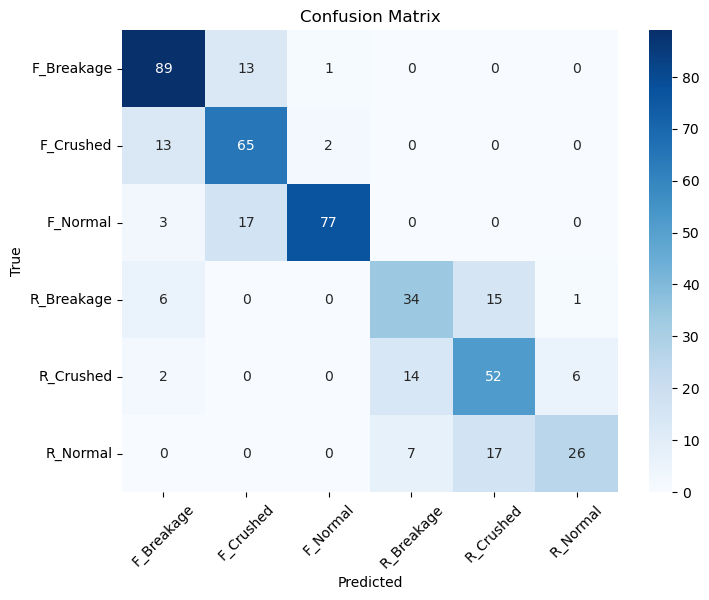

In [175]:
# Evaluate on test set
all_preds, all_labels = test_model(trained_model_with_resnet, test_loader)
classification_report_matrix(all_labels, all_preds, class_names)

### Save the Model

In [176]:
torch.save(trained_model_with_resnet.state_dict(), 'app/model/car_damage_classification.pth')